# Кластерный анализ комментариев

Оценим будущее моделирование средствами кластерного анализа.

Кластерный анализ текстовых данных может быть полезен для решения различных задач:
1) Выявление тематических групп: автоматическое выделение групп комментариев, которые обсуждают схожие темы, даже если они выражены разными словами.
2) Поиск аномалий: кластеризация помогает обнаружить комментарии, которые не вписываются в общие паттерны, что может быть полезно для выявления спама, троллинга или других нестандартных высказываний.
3) Улучшение интерпретации данных: группировка комментариев позволяет лучше понять структуру данных и выделить ключевые темы, которые волнуют пользователей.

**Цель данной тетрадки**: построить кластерный анализ и глубже разобраться в данных, понять насколько разочимы классы, оценить будущее моделирование.   

**В ходе проекта выполнено**:  
1) `Загрузка и трансформация данных`: загружены необходимые библиотеки, создан ряд вспомогательных функций, загружены комментарии и их эмбеддинги;
2) `Кластерный анализ`:
   * Алгоритм K-Means: подобрано оптимально число кластеров с помощью **метода локтя**, оценено распределение меток в каждом кластере, определены самые популярные слова и биграммы в каждом кластере;
   * Алгортим агломеративной иерархической кластеризации: подобрано оптимально число кластеров с помощью **метода силуэта**, оценено распределение меток в каждом кластере, определены самые популярные слова и биграммы в каждом кластере;
3) `Анализ результатов и UMAP-анализ`

**Общий вывод по кластерному анализу:**  
Построены два алгоритма кластеризации - k-means и агломеративная иерархическая кластеризация.  
`Алгоритм k-means` построенный на 9 кластеров показал незначительный результат: кластеры 0 и 8 неплохо показывают положительные комментарии. В 5-ом кластере больше говорят об благодарности и дают положительные оценки. В 6-ом кластере говорят о "первой части" и дают хорошие оценки - там больше всего нейтральных комментариев. 0 кластер - положительные комментарии, а 2 кластер - крайне негативные. Какие-то темы выделить не удалось. Это говорит о том, что некая тематика у кластеров есть, хоть и небольшая;  
`Алгоритм агломеративной иерархической кластеризации` показал более интересный результат: при 8 кластерах получилась более интересное распределение - есть кластеры, в которых почти нет нейтральных комментариев, также есть кластеры с подавляющим большинством положительных. Изучим кластеры при 8 кластерах. Cамые популярные слова и биграммы в кластерах 3, 6, 2 носят положительную тональность (благодарности и хвалебные высказвания). В кластерах 1 и 4 нет явной тематики и больше похоже на спам. Остальные кластеры носят нейтральный и негативный характер. Это говорит о том, что в принципе, тональность моделируема.  
И, наконец, анализ UMAP-карты показал, что в **тональность действительно можно обнаружить**, поэтому моделирование оправдано.

## Загрука данных

Импорт необходимых библиотек.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import statistics
import umap

from transformers import AutoModelForSequenceClassification, BertTokenizerFast, pipeline
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform

DATA_PATH = 'all_comments_with_target.csv'
DATA_PATH_EMB = 'comments_embeddings_with_target.csv'
DATA_PATH_LEMM = 'lemmatize_comments.csv'

RANDOM_STATE = 42

In [2]:
import warnings

# Отключение предупреждений
warnings.filterwarnings('ignore')

Создание вспомогательных функций.

In [3]:
# Функция для оценки качества кластеризации
def clusterization_quality(k, wss, mean_wss, median_wss, mean_mid):
    k_values_i = range(1, k)
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(3, 3, height_ratios=[0.5, 0.05, 0.5])
    
    # Верхний ряд: три графика
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    
    # Нижний график (по центру)
    ax4 = fig.add_subplot(gs[2, 1])
    
    # График 1: Метод локтя
    ax1.plot(k_values, wss, marker='o')
    ax1.set_title("Метод локтя")
    ax1.set_xlabel("Число кластеров (k)")
    ax1.set_ylabel("Inertia")
    ax1.set_xticks(k_values)
    
    # График 2: Среднее WSS
    ax2.plot(k_values, mean_wss, marker='o')
    ax2.set_title("Среднее WSS")
    ax2.set_xlabel("Число кластеров (k)")
    ax2.set_ylabel("Среднее расстояние")
    ax2.set_xticks(k_values)
    
    # График 3: Медианное WSS
    ax3.plot(k_values, median_wss, marker='o')
    ax3.set_title("Медианное WSS")
    ax3.set_xlabel("Число кластеров (k)")
    ax3.set_ylabel("Медианное расстояние")
    ax3.set_xticks(k_values)
    
    # График 4: Среднее расстояние между кластерами
    ax4.plot(k_values, mean_mid, marker='o')
    ax4.set_title("Среднее расстояние между центроидами")
    ax4.set_xlabel("Число кластеров (k)")
    ax4.set_ylabel("MID")
    ax4.set_xticks(k_values)
    
    plt.tight_layout()
    plt.show()

# Изучение распределения меток классов в кластерах
def cluster_and_visualize(model, data, n_clusters=None):
    if hasattr(model, 'n_clusters'):
        model.n_clusters = n_clusters
        
    labels = model.fit_predict(data.drop('Оценка комментария', axis=1))

    label_data = pd.DataFrame({'label': labels, 'real_class': list(data['Оценка комментария'])})
    cluster_counts = label_data.groupby(['label', 'real_class'])['real_class'].count()

    # Pivot data for visualization
    pivot_data = cluster_counts.unstack(fill_value=0)

    # Plotting
    fig, ax = plt.subplots(figsize=(15, 4))
    colors = ['#CBCBCB', '#DE5454', '#2DDC6D']  # Updated for 3 classes
    bars = []

    for i, real_class in enumerate(pivot_data.columns):
        if i == 0:
            bars.append(ax.barh(pivot_data.index, pivot_data[real_class], color=colors[i], label=f'Class {real_class}'))
        else:
            bars.append(ax.barh(
                pivot_data.index, pivot_data[real_class],
                left=pivot_data.iloc[:, :i].sum(axis=1),
                color=colors[i], label=f'Class {real_class}'
            ))

    # Add total counts for each cluster
    total_counts = pivot_data.sum(axis=1)
    max_total = total_counts.max()
    ax.set_xlim(0, max_total * 1.2)

    for idx, total in enumerate(total_counts):
        counts = ", ".join(map(str, pivot_data.iloc[idx].tolist()))
        ax.text(total + max_total * 0.02, idx, f"({counts})", va='center', fontsize=10)

    # Configure the plot
    ax.set_yticks(pivot_data.index)
    ax.set_yticklabels([f'Cluster {i}' for i in pivot_data.index])
    ax.set_xlabel('Количество реальных меток')
    ax.set_title(f'Распределение реальных классов при k={n_clusters}')
    ax.legend(title='Класс')

    plt.tight_layout()
    plt.show()


# Изучение популярных слов и биграмм в каждом кластере
def analyze_clusters(data):
    clusters = data['cluster_label'].unique()
    num_clusters = len(clusters)

    fig, axes = plt.subplots(num_clusters, 2, figsize=(8, 3 * num_clusters))

    for idx, cluster in enumerate(clusters):
        cluster_data = data[data['cluster_label'] == cluster]

        # Подсчет униграмм
        vectorizer_uni = CountVectorizer()
        X_uni = vectorizer_uni.fit_transform(cluster_data['lemmatized_comments'])
        word_counts = X_uni.sum(axis=0).A1
        vocab = vectorizer_uni.get_feature_names_out()
        word_freq = dict(zip(vocab, word_counts))
        top_words = Counter(word_freq).most_common(5)

        # Подсчет биграмм
        vectorizer_bi = CountVectorizer(ngram_range=(2, 2))
        X_bi = vectorizer_bi.fit_transform(cluster_data['lemmatized_comments'])
        bigram_counts = X_bi.sum(axis=0).A1
        bigram_vocab = vectorizer_bi.get_feature_names_out()
        bigram_freq = dict(zip(bigram_vocab, bigram_counts))
        top_bigrams = Counter(bigram_freq).most_common(5)

        # Визуализация в виде матрицы
        sns.barplot(
            x=[count for word, count in top_words], 
            y=[word for word, count in top_words], 
            ax=axes[idx][0], palette="Blues_d"
        )
        axes[idx][0].set_title(f'Топ-5 слов (Кластер {cluster})')
        axes[idx][0].tick_params(labelsize=8)

        sns.barplot(
            x=[count for bigram, count in top_bigrams], 
            y=[bigram for bigram, count in top_bigrams], 
            ax=axes[idx][1], palette="Greens_d"
        )
        axes[idx][1].set_title(f'Топ-5 биграмм (Кластер {cluster})')
        axes[idx][1].tick_params(labelsize=8)

    plt.tight_layout()
    plt.show()

Загрузка данных.

In [4]:
comments = pd.read_csv(DATA_PATH, sep=';')
comments_embeddings_with_target = pd.read_csv(DATA_PATH_EMB, sep=';')
comments_lemmatize = pd.read_csv(DATA_PATH_LEMM, sep=';')

In [5]:
comments.head()

,Комментарий RuTube,Оценка комментария
0,Это пушка!!!??,положительный
1,"я еще не досмотрела, но ведь, посмотрите, а Би...",нейтральный
2,Как же я кайфанула)))),положительный
3,говнище и бред!,отрицательный
4,Фильм очень прикольный. Его сложно будет понят...,положительный


In [6]:
comments.isna().sum()

Комментарий RuTube    0
Оценка комментария    0
dtype: int64

In [7]:
comments_embeddings_with_target.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767,Оценка комментария
0,-0.504641,-0.233505,0.639951,-0.066592,0.364267,1.263998,0.940735,0.267666,-0.590703,0.646024,...,1.020222,-1.433715,-0.764953,0.157131,0.310580,0.044016,1.412764,0.161786,-0.094626,положительный
1,-0.291139,-0.360141,-0.016272,-0.570844,0.083912,0.655268,0.480027,0.100380,0.607182,0.307070,...,-0.016707,-1.192877,0.152845,0.865718,0.021958,0.205061,0.485227,0.178334,-0.582408,нейтральный
2,0.491792,-0.482384,-0.006477,1.147053,-0.088107,0.639690,-0.639552,-0.703718,-0.247541,0.685628,...,0.235107,-0.057627,-0.563450,0.078974,-0.491394,1.128431,-0.493944,0.090925,0.131741,положительный
3,-0.308080,0.066670,-1.130417,0.585710,0.437479,0.964606,-0.099412,0.151958,0.885810,0.015793,...,0.192393,-0.517052,0.200269,0.386341,-0.106624,-0.521604,0.268278,0.037221,-0.087667,отрицательный
4,-0.242632,-0.444915,0.284799,-0.240497,0.250947,0.858896,0.461499,0.157919,-0.312827,0.202954,...,-0.129889,-0.424944,-0.584311,0.471113,-0.020785,-0.277168,0.755969,0.195199,-0.372174,положительный


In [8]:
comments_embeddings_with_target.isna().sum().sum()

0

In [9]:
comments_lemmatize.head()

,lemmatized_comments
0,пушка
1,не досмотреть посмотреть битлджус мужик лишний...
2,кайфанула
3,говнище бред
4,фильм прикольный сложный понять не смотреть ча...


In [10]:
comments_lemmatize.isna().sum()

lemmatized_comments    51
dtype: int64

In [11]:
comments_lemmatize = comments_lemmatize.fillna('не удалось лемматизировать')

In [12]:
comments_lemmatize.isna().sum()

lemmatized_comments    0
dtype: int64

## Кластерный анализ

Проведём кластерный анализ. Построим несколько алгоритмов кластеризации и выберем лучший.

### Алгоритм K-Means

Найдем лучшее количество кластеров с помощью метода локтя. Также рассмотрим средние и медианные расстояния внутри каждого кластера (берём средние расстояния внутри кластеров и все такие средние расстояния усредняем; тоже самое далаем с медианами - возьмём медианные значения расстояний от точек кластера до его центроиды, а результат усредним)

#### Подберём количество кластеров с помощью метода локтя

In [13]:
k_values = range(1, 17)
inertia_values = []        # сумма внутрикластерных расстояний (wss)
mean_distances_list = []   # средние внутрикластерные расстояния
median_distances_list = [] # медианные внутрикластерные расстояния
mid_list = []              # средние расстояния между центрами кластеров
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    kmeans.fit(comments_embeddings_with_target.drop('Оценка комментария', axis=1))

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Метод локтя
    inertia_values.append(kmeans.inertia_)

    # Вычисление межкластерных расстояний
    distances_between_centroids = pairwise_distances(centroids, metric='euclidean')
    n_clusters = len(centroids)
    triu_indices = np.triu_indices(n_clusters, k=1)
    nonzero_distances = distances_between_centroids[triu_indices]
    mid_list.append(np.mean(nonzero_distances))
    
    # Обнуление списков перед вычислением
    mean_distances = []
    median_distances = []
    
    # Среднее квадратичное расстояние кластеров
    for cluster_id in range(kmeans.n_clusters):
        # Выбираем точки из текущего кластера
        cluster_points = comments_embeddings_with_target.drop('Оценка комментария', axis=1)[labels == cluster_id]
        cluster_center = centroids[cluster_id].reshape(1, -1)

        # Вычисляем расстояния от точек до центра
        distances = pairwise_distances(cluster_points, cluster_center, metric='euclidean')
        mean_distances.append(statistics.mean(distances.flatten()))
        median_distances.append(statistics.median(distances.flatten()))

    # Добавляем результаты для текущего k в вложенные списки
    mean_distances_list.append(statistics.mean(mean_distances))
    median_distances_list.append(statistics.mean(median_distances))

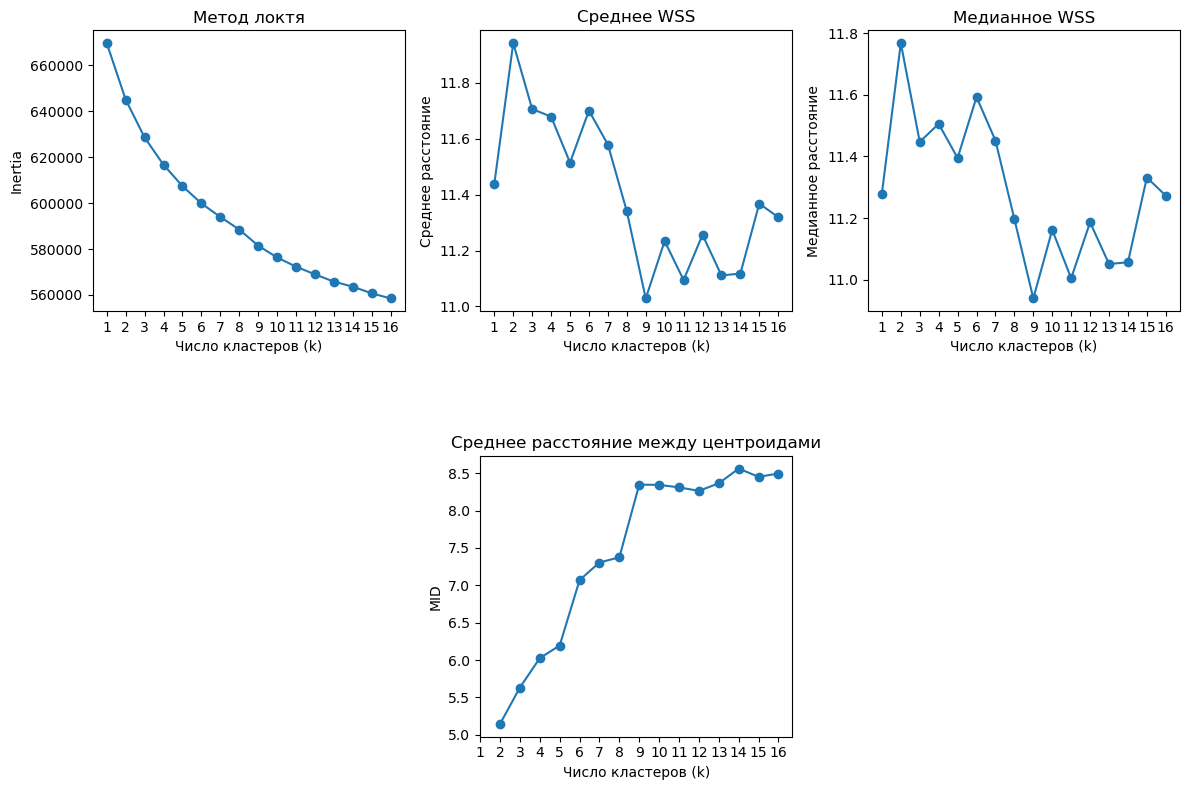

In [14]:
clusterization_quality(17, inertia_values, mean_distances_list, median_distances_list, mid_list)

**Итого**: метод локтя не показал "перегиб", поэтому будем выбирать подходящее число кластеров из оставшихся графиков. Заметим, что самое маленькое внутрикластерное расстояние (среднее и медианное) наблюдается при 9 кластерах. Также самое большое среднее расстояние между центроидами также наблюдается при 9 кластерах.

#### Оценка распределения меток

Изучим, как распределены метки классов тональности в этих кластерах. 

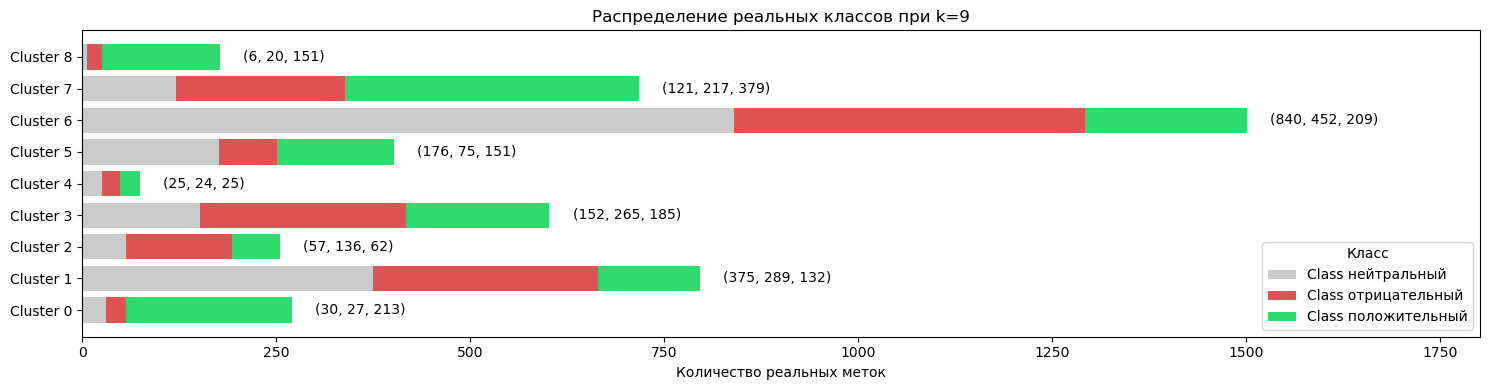

In [15]:
cluster_and_visualize(KMeans(random_state=RANDOM_STATE), comments_embeddings_with_target, 9)

**Итого**: распределение меток классов по кластерам носит случайный характер. Наши кластеры не отражают тональность. Но заметим, что кластеры 0 и 8 неплохо показывают положительные комментарии.

#### Анализ популярных n-gramm в кластерах

Рассмотрим самые популярные слова и биграммы в каждом кластере. Это поможет нам определить тематику комментариев.

In [16]:
kmeans = KMeans(n_clusters=9, random_state=RANDOM_STATE)
kmeans.fit(comments_embeddings_with_target.drop('Оценка комментария', axis=1))

kmns_labels = pd.DataFrame({'cluster_label': kmeans.labels_})

In [17]:
comments_lemmatize_kmns_label = pd.concat([comments_lemmatize, kmns_labels], axis=1)

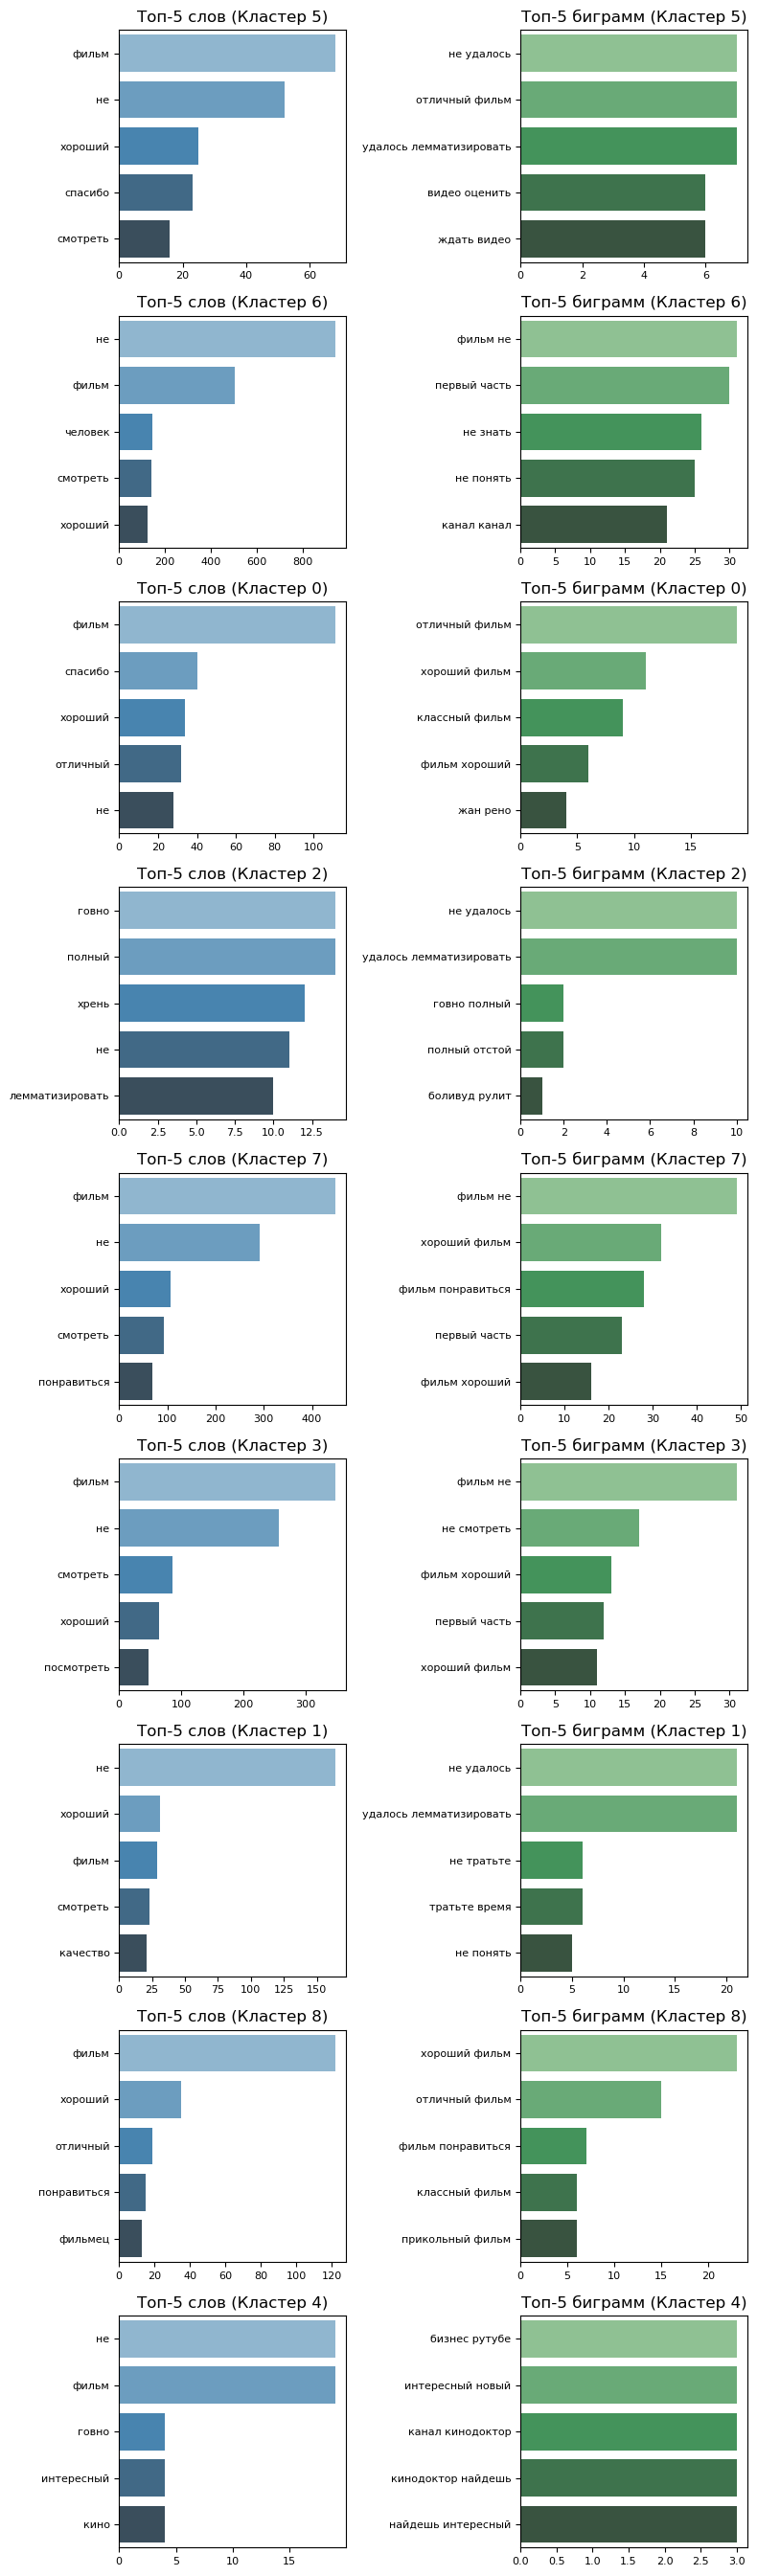

In [18]:
analyze_clusters(comments_lemmatize_kmns_label)

**Итого**: поскольку при лемматизации комментариев частица "не" не удалялась, то она встречается практически в каждом кластере как популярная. Делалось это для построения более правильных биграмм. Что касается популярности слов в биграммах, то в 5-ом кластере больше говорят об благодарности и дают положительные оценки. В 6-ом кластере говорят о "первой части" и дают хорошие оценки - там больше всего нейтральных комментариев. 0 кластер - положительные комментарии, а 2 кластер - крайне негативные. Какие-то темы выделить не удалось.

### Алгоритм агломеративной иерархической кластеризации

Найдём наилучшее число кластеров с помощью метода силуэта.

#### Нахождение количества кластеров с помощью метода силуэта

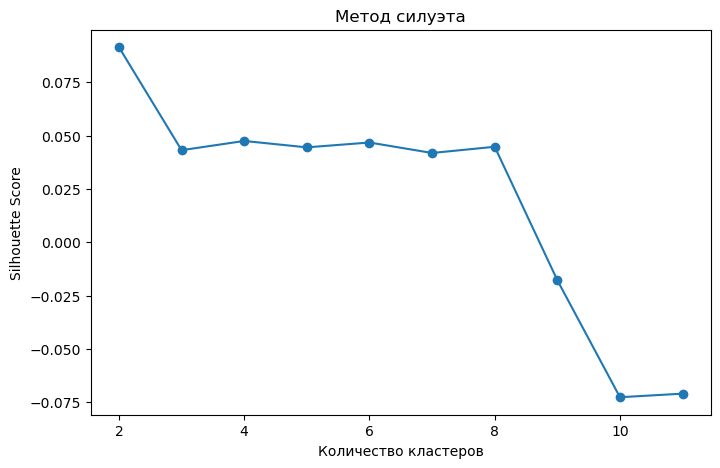

In [19]:
silhouette_scores = []

# Тестируем разные числа кластеров
for k_i in range(2, 12):
    model = AgglomerativeClustering(n_clusters=k_i)
    labels = model.fit_predict(comments_embeddings_with_target.drop('Оценка комментария', axis=1))
    silhouette_scores.append(silhouette_score(comments_embeddings_with_target.drop('Оценка комментария', axis=1), labels))

# Построение графика
plt.figure(figsize=(8, 5))
plt.plot(range(2, 12), silhouette_scores, marker='o')
plt.title('Метод силуэта')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')
plt.show()

**Итого**: наблюдаем пик при 2 и 8 кластерах.

#### Оценка распределения меток

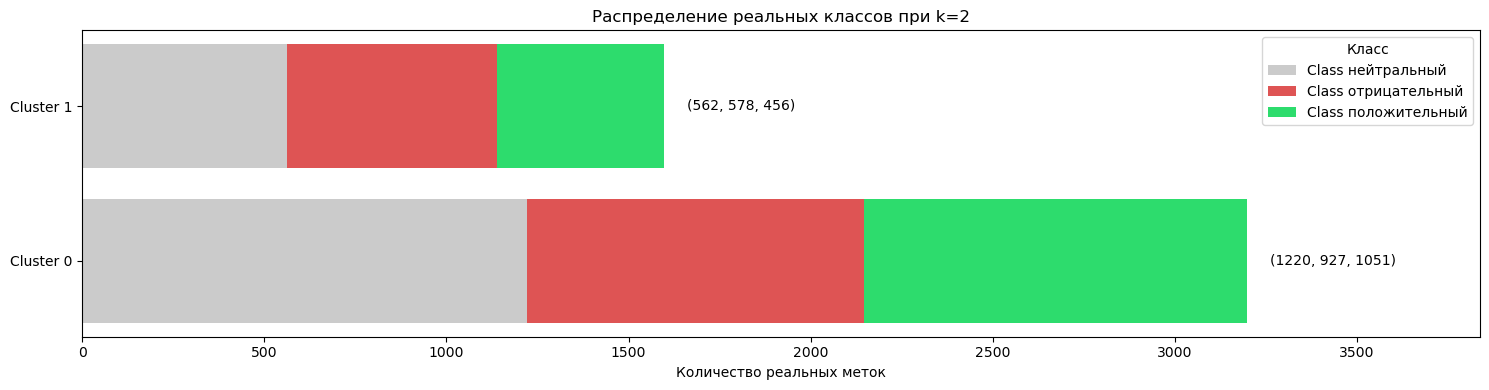

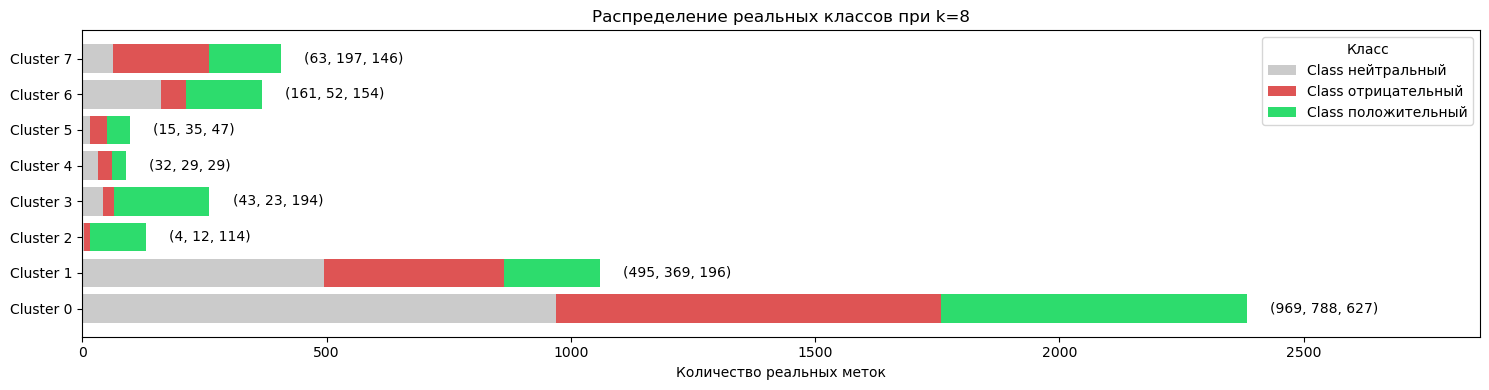

In [20]:
for clusters_i in [2, 8]:
    cluster_and_visualize(AgglomerativeClustering(), comments_embeddings_with_target, clusters_i)

**Итого**: при 8 кластерах получилась более интересное распределение - есть кластеры, в которых почти нет нейтральных комментариев, также есть кластеры с подавляющим большинством положительных. Изучим кластеры при 8 кластерах.

#### Анализ популярных n-gramm в кластерах

In [21]:
aglomerative = AgglomerativeClustering(n_clusters=8)
aglomerative.fit(comments_embeddings_with_target.drop('Оценка комментария', axis=1))

aglomerative_labels = pd.DataFrame({'cluster_label': aglomerative.labels_})

In [22]:
comments_lemmatize_aglomerative_label = pd.concat([comments_lemmatize, aglomerative_labels], axis=1)

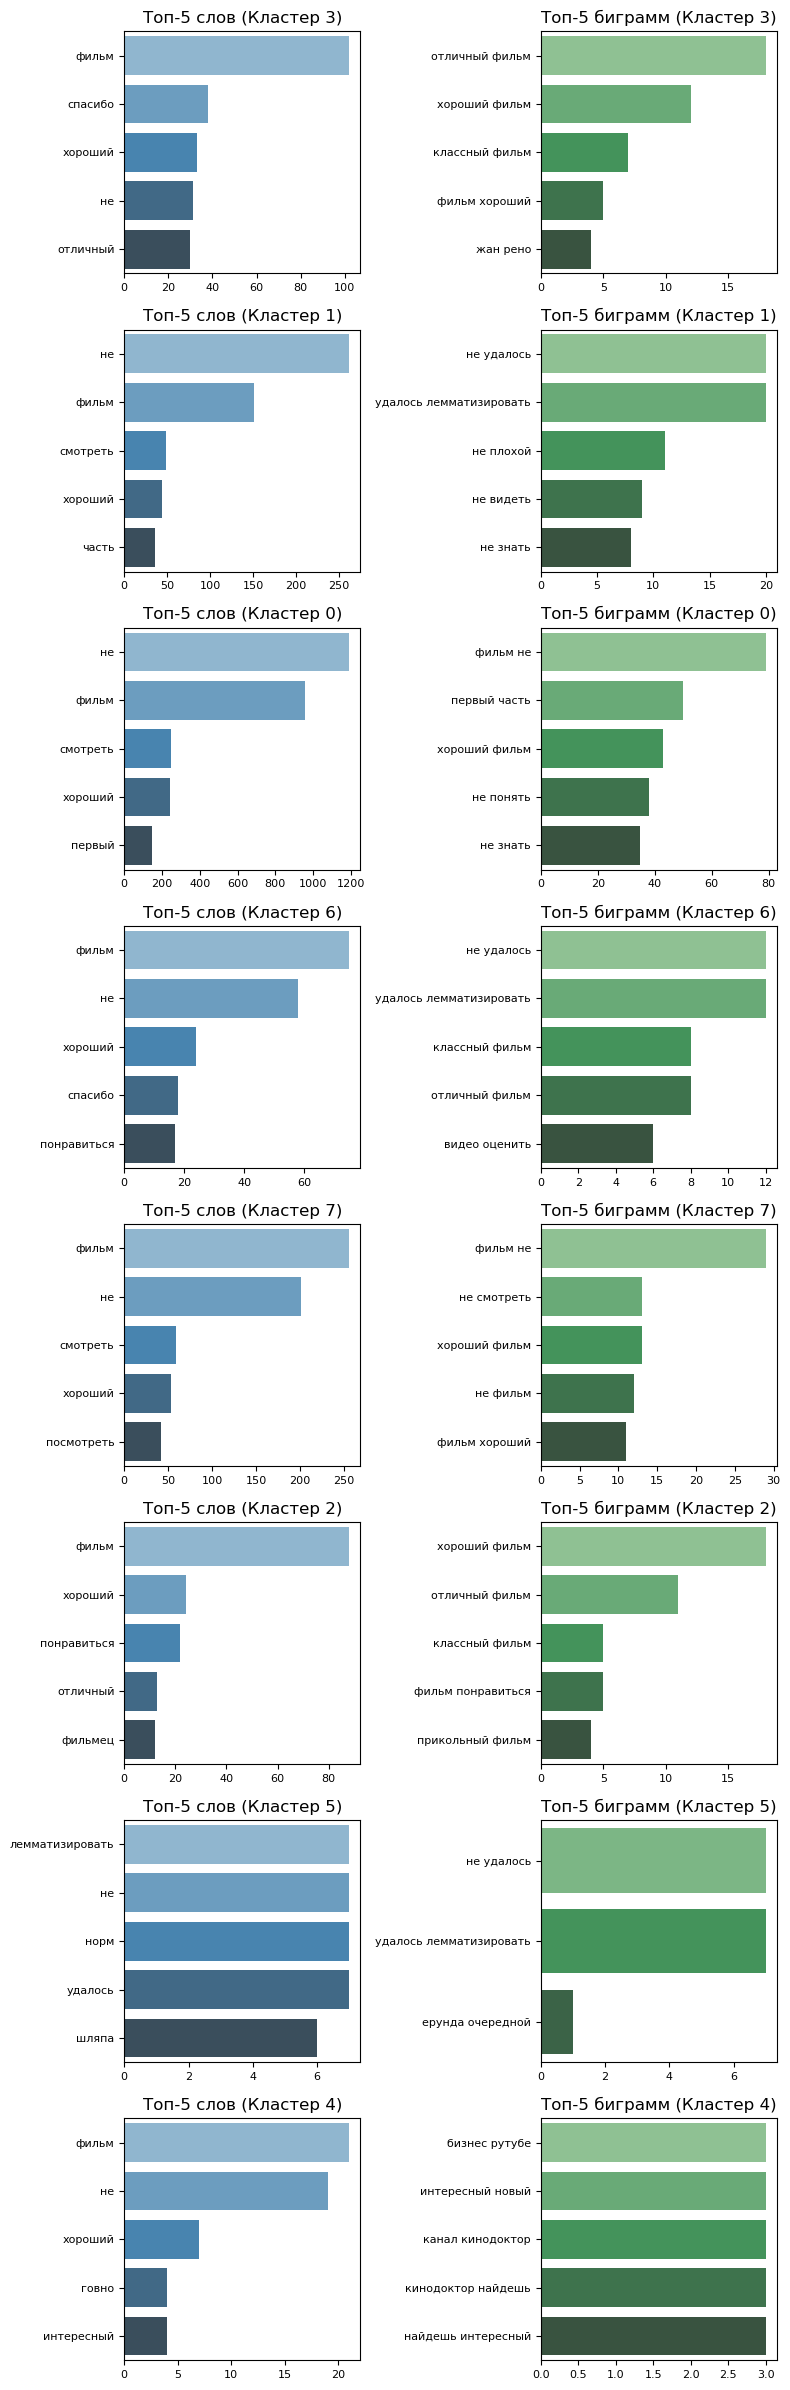

In [23]:
analyze_clusters(comments_lemmatize_aglomerative_label)

**Итого**: самые популярные слова и биграммы в кластерах 3, 6, 2 носят положительную тональность (благодарности и хвалебные высказвания). В кластерах 1 и 4 нет явной тематики и больше похоже на спам. Остальные кластеры носят нейтральный и негативный характер.

## Анализ результатов и UMAP-анализ

Кажется, что агломеративная кластеризация показала себя лучше - в кластерах можно найти спам, положительные, отрицательные и нейтральные комментарии. Кластеры получились более "объективными".

### UMAP-анализ на размеченных классах

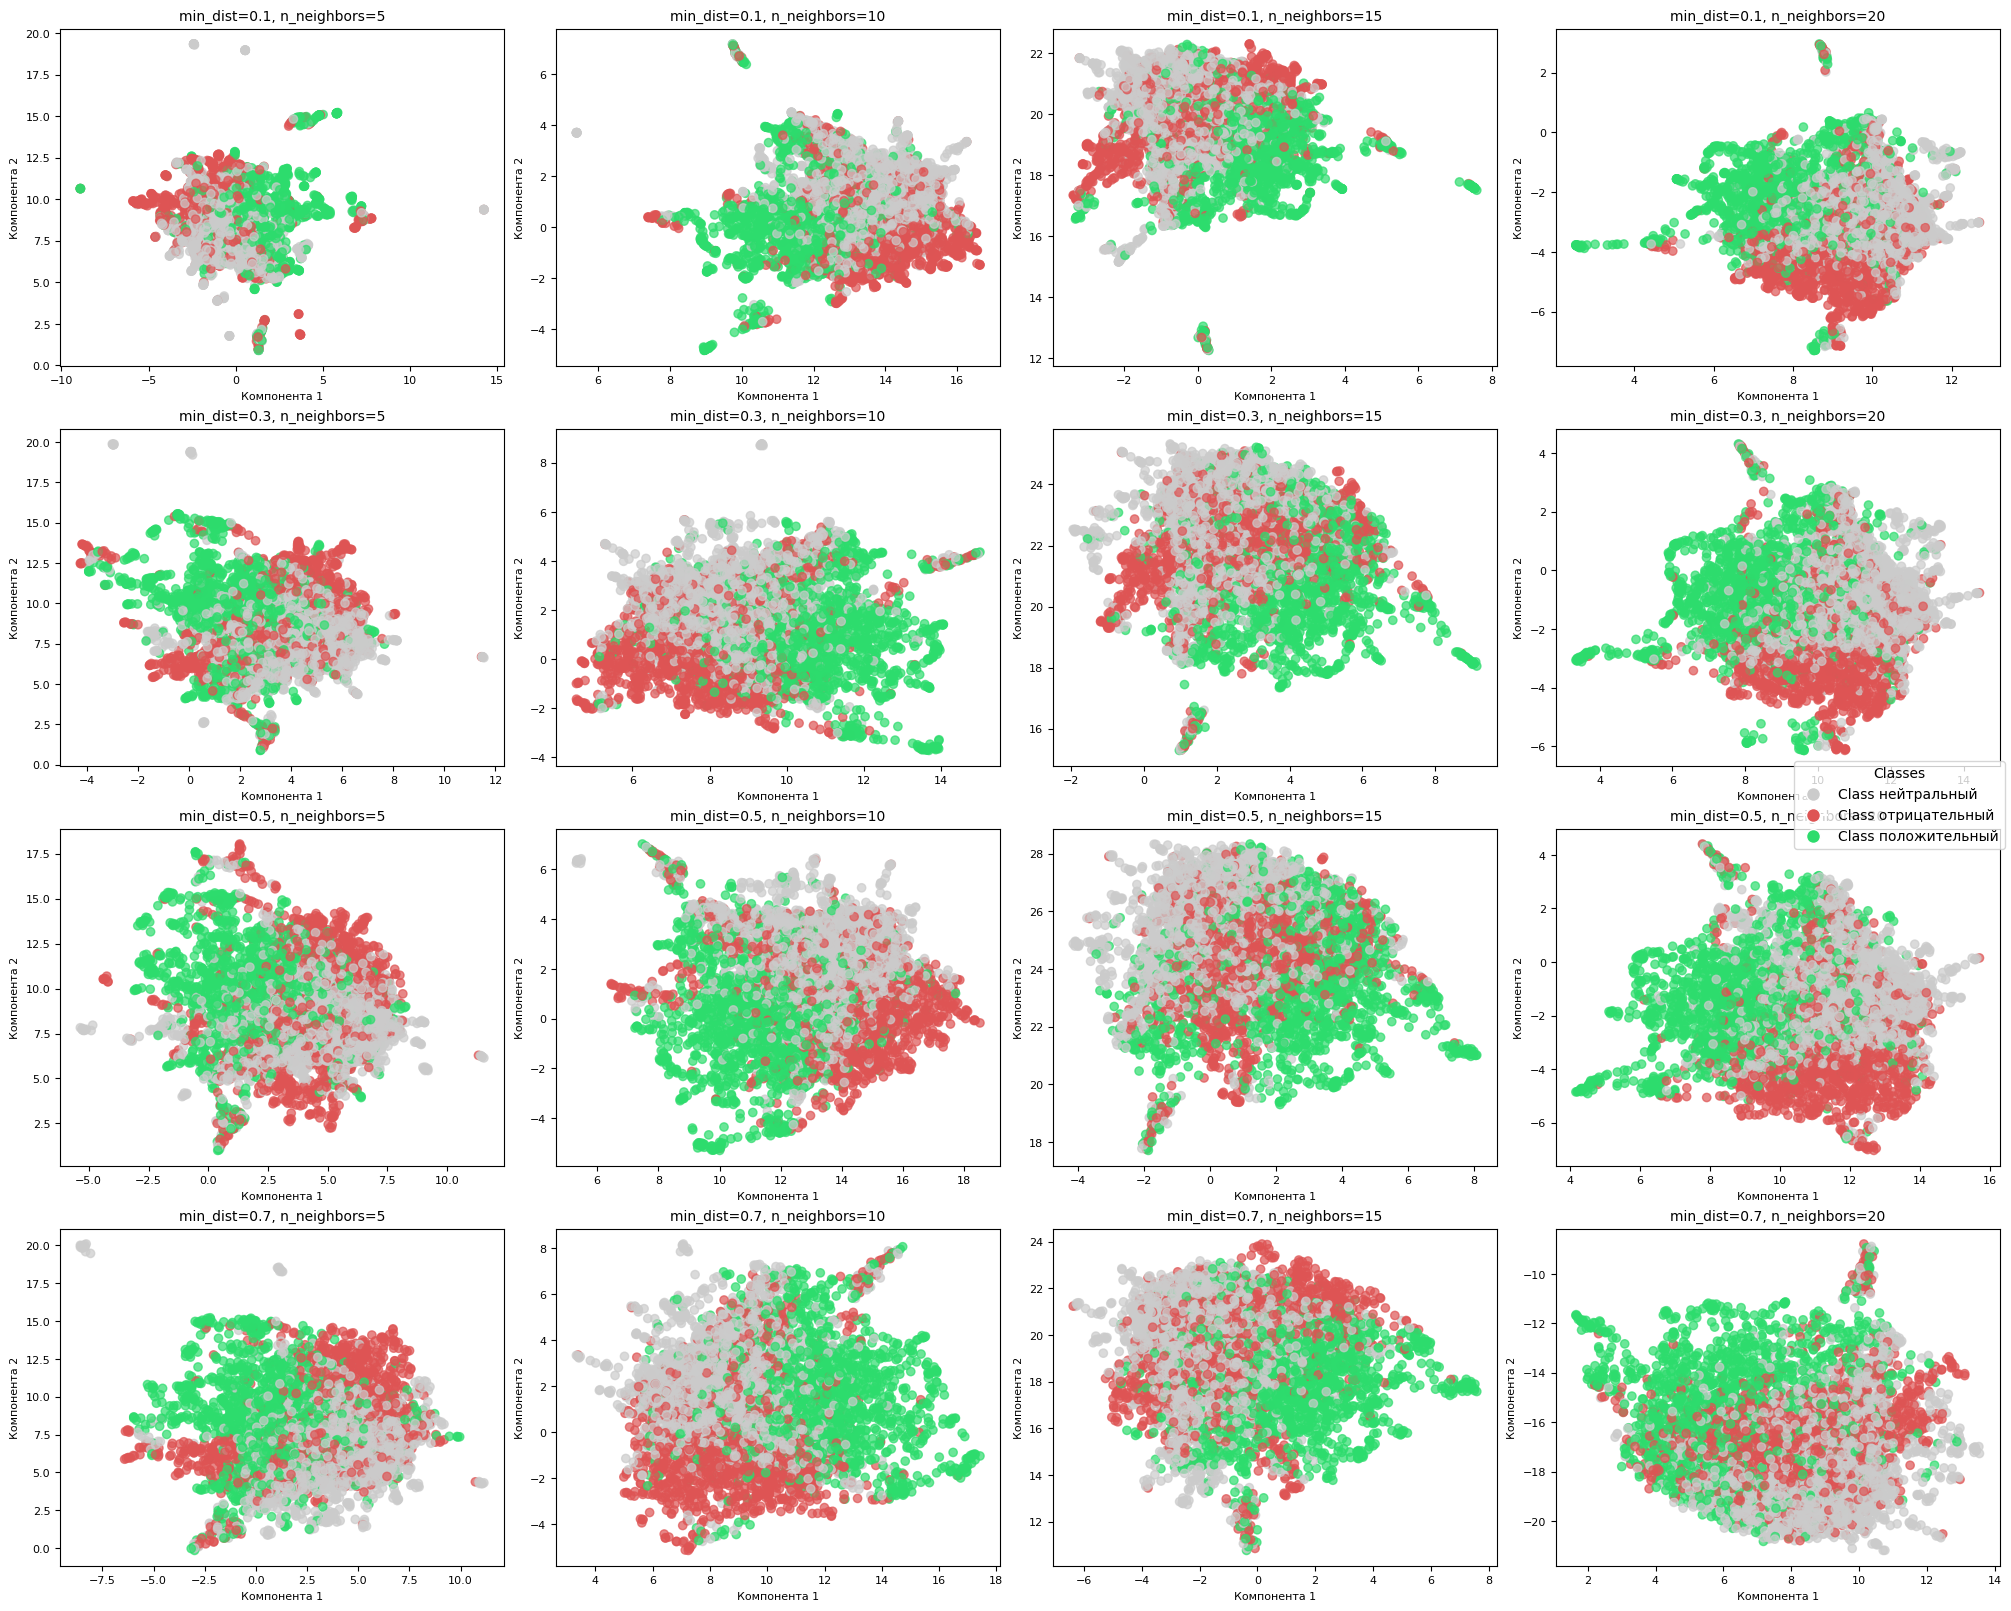

In [24]:
class_colors = {
    'нейтральный': '#CBCBCB',
    'отрицательный': '#DE5454',
    'положительный': '#2DDC6D'
}

min_dist_values = [0.1, 0.3, 0.5, 0.7]
n_neighbors_values = [5, 10, 15, 20]

labels = comments_embeddings_with_target['Оценка комментария']
colors = [class_colors[label] for label in labels]

fig, axes = plt.subplots(len(min_dist_values), len(n_neighbors_values), figsize=(20, 16), constrained_layout=True)

for i, min_dist_i in enumerate(min_dist_values):
    for j, n_neighbors_i in enumerate(n_neighbors_values):
        reducer = umap.UMAP(
            n_neighbors=n_neighbors_i,
            min_dist=min_dist_i,
            n_components=2,
            random_state=RANDOM_STATE
        )

        embedding = reducer.fit_transform(
            comments_embeddings_with_target.drop('Оценка комментария', axis=1)
        )

        ax = axes[i, j]
        ax.scatter(
            embedding[:, 0],
            embedding[:, 1],
            c=colors,
            alpha=0.7
        )

        ax.set_title(f'min_dist={min_dist_i}, n_neighbors={n_neighbors_i}', fontsize=10)
        ax.set_xlabel('Компонента 1', fontsize=8)
        ax.set_ylabel('Компонента 2', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=8)

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'Class {cls}', 
                              markerfacecolor=color, markersize=10) 
                   for cls, color in class_colors.items()]
fig.legend(handles=legend_elements, title='Classes', loc='center right', fontsize=10)
plt.show()

**Итого**: при min_dist=0.5 и n_neighbors=20 (3ий ряд, четверый график) видно, что тональность комментариев довольно хорошо различима - слева расположились положительные комментарии, справа - нейтральные, а внизу - отрицательные. Так что совершенно очевидно, что **классы различимы и моделирование стоит проводить.**